In [1]:
import pandas as pd
#Read in dataset
df = pd.read_csv("movies_topic_modeling.csv")

#Dropping non-numeric variables
df = df.drop([ "Title", "overview", "tagline", "overview_processes"], axis=1)
df = pd.get_dummies(df, columns=['Rating'], drop_first=False) # one hot encoding
df["Movie_Hits"] = df["Movie_Hits"].fillna(0) #filling in NA values with 0 if there are no hits


Best params for Netflix: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best CV AUC for Netflix: 0.7112

Best params for Hulu: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best CV AUC for Hulu: 0.6723

Best params for Prime Video: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
Best CV AUC for Prime Video: 0.7602

Best params for Disney+: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV AUC for Disney+: 0.9525


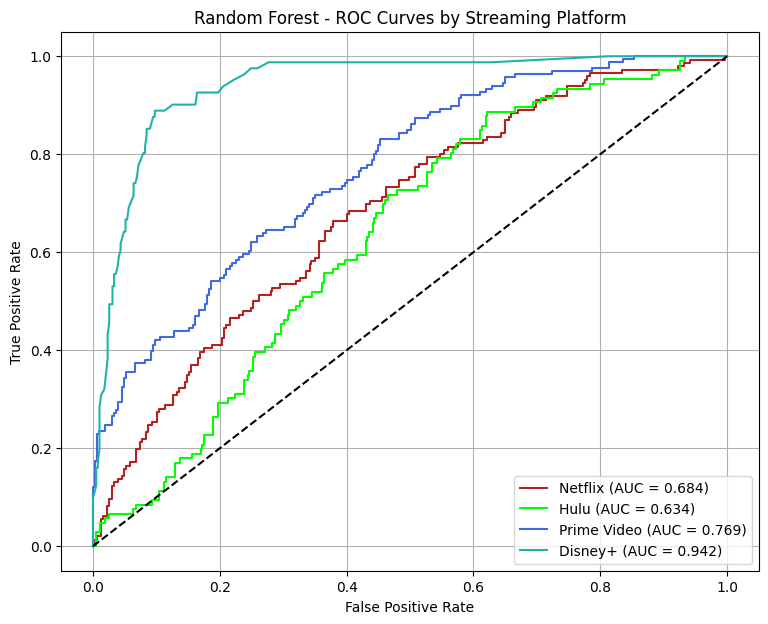

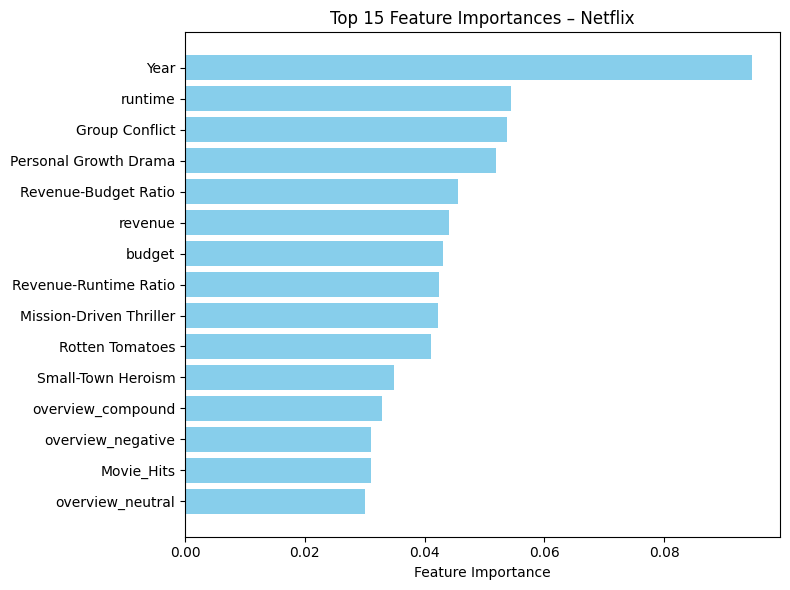

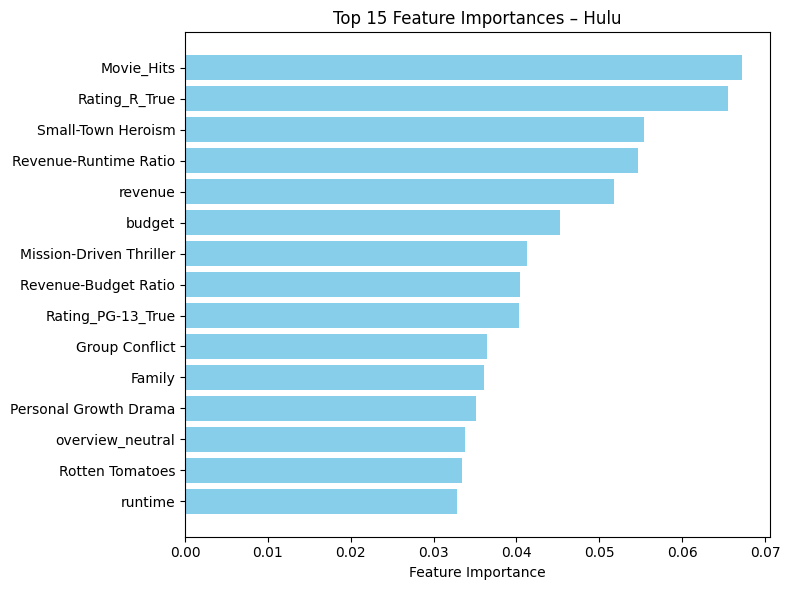

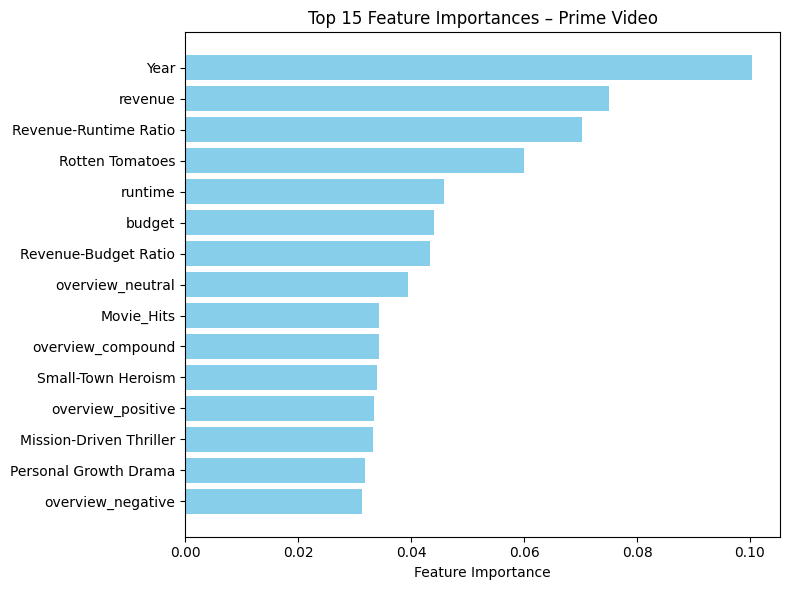

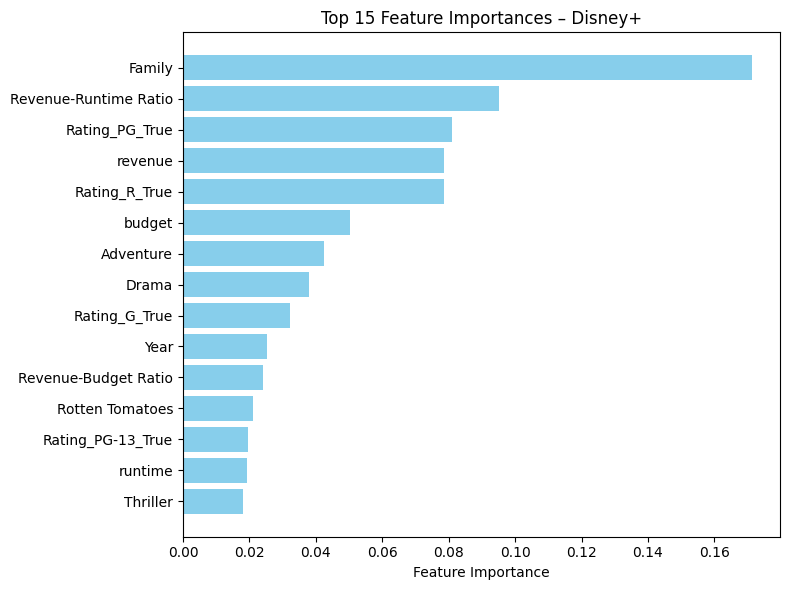


===== PERFORMANCE METRICS =====
      Platform  Accuracy  F1 Score  Sensitivity  Specificity  Test AUC  \
0      Netflix  0.634820  0.530055     0.664384     0.621538  0.683646   
1         Hulu  0.492569  0.440281     0.886792     0.378082  0.633704   
2  Prime Video  0.647558  0.624434     0.831325     0.547541  0.768576   
3      Disney+  0.900212  0.753927     0.888889     0.902564  0.942118   

   Best Threshold  
0        0.411750  
1        0.236536  
2        0.391813  
3        0.320000  


In [3]:
# =============================
# IMPORTS
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# =============================
# DATA PREP
# =============================
#Defining targets for model
targets = ["Netflix", "Hulu", "Prime Video", "Disney+"]
X = df.drop(columns=targets)

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Pre processing data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ]
)

# =============================
# STORAGE
# =============================
roc_info = {}
best_thresholds = {}
best_params = {}
performance_table = []
best_models = []
valid_targets = []

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# =============================
# MODEL TRAINING PER TARGET
# =============================
best_models = {}  # store best model per platform

for t in targets:
    y = df[t]

    if y.sum() < 5:
        print(f"Skipping {t}: too few positive samples ({y.sum()})")
        continue

    valid_targets.append(t)

    # Train-test split
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Preprocess
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)

    # Pipeline: SMOTE + Random Forest
    pipe = Pipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42, class_weight="balanced"))
    ])

    # Hyperparameter grid
    param_grid = {
        "rf__n_estimators": [100, 300],
        "rf__max_depth": [None, 5, 10],
        "rf__min_samples_split": [2, 5],
        "rf__min_samples_leaf": [1, 2]
    }

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv_outer,
        n_jobs=-1
    )

    # Fit
    grid.fit(X_train, y_train)
    best_params[t] = grid.best_params_
    print(f"\nBest params for {t}: {grid.best_params_}")
    print(f"Best CV AUC for {t}: {grid.best_score_:.4f}")

    best_model = grid.best_estimator_
    best_models[t] = best_model  # store for importance plots

    # Predict probabilities
    prob_test = best_model.predict_proba(X_test)[:, 1]

    # Threshold tuning (Youden's J)
    fpr, tpr, thresholds = roc_curve(y_test, prob_test)
    best_thr = thresholds[np.argmax(tpr - fpr)]
    best_thresholds[t] = best_thr
    roc_auc = auc(fpr, tpr)
    roc_info[t] = (fpr, tpr, roc_auc)

    # Apply threshold
    y_pred = (prob_test >= best_thr).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    performance_table.append({
        "Platform": t,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Test AUC": roc_auc,
        "Best Threshold": best_thr
    })

# =============================
# ROC CURVES
# =============================
# =============================
# PLOT ROC CURVES (with custom colors)
# =============================

color_map = {
    "Netflix": "firebrick",
    "Hulu": "lime",
    "Prime Video": "royalblue",
    "Disney+": "lightseagreen"
}

plt.figure(figsize=(9, 7))
for t in valid_targets:
    fpr, tpr, auc_score = roc_info[t]
    plt.plot(
        fpr, tpr,
        label=f"{t} (AUC = {auc_score:.3f})",
        color=color_map.get(t, None)   # default None in case of missing
    )

plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curves by Streaming Platform")
plt.legend()
plt.grid(True)
plt.show()


# =============================
# FEATURE IMPORTANCE PLOTS
# =============================
TOP_N = 15

for t in valid_targets:
    rf_model = best_models[t].named_steps["rf"]  # per-platform model

    # Feature names after preprocessing
    ohe_cols = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
    feature_names = list(num_cols) + list(ohe_cols)

    importances = rf_model.feature_importances_

    # Sort descending
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:TOP_N]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]

    # Reverse for horizontal bar chart (largest on top)
    top_features_rev = top_features[::-1]
    top_importances_rev = top_importances[::-1]

    plt.figure(figsize=(8,6))
    plt.barh(range(TOP_N), top_importances_rev, color='skyblue')
    plt.yticks(range(TOP_N), top_features_rev)
    plt.xlabel("Feature Importance")
    plt.title(f"Top {TOP_N} Feature Importances – {t}")
    plt.tight_layout()
    plt.show()

# =============================
# PERFORMANCE TABLE
# =============================
perf_df = pd.DataFrame(performance_table)
print("\n===== PERFORMANCE METRICS =====")
print(perf_df)
